<a href="https://colab.research.google.com/github/kschoi93/AI/blob/master/torch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install torch
!pip install numpy

In [10]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
dataset = pd.read_csv('/content/drive/MyDrive/080289-main/080289-main/chap02/data/car_evaluation.csv')
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


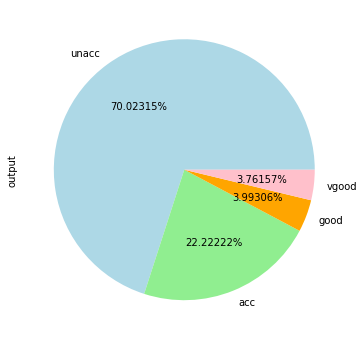

In [13]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
dataset.output.value_counts().plot(kind='pie', autopct='%0.05f%%', colors=['lightblue', 'lightgreen', 'orange', 'pink'])

In [14]:
categorical_columns = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety']

for category in categorical_columns:
    dataset[category] = dataset[category].astype('category')

price = dataset['price'].cat.codes.values
maint = dataset['maint'].cat.codes.values
doors = dataset['doors'].cat.codes.values
persions = dataset['persons'].cat.codes.values
lug_capacity = dataset['lug_capacity'].cat.codes.values
safety = dataset['safety'].cat.codes.values

categorical_data = np.stack([price, maint, doors, persions, lug_capacity, safety], 1)
categorical_data[:10]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

In [16]:
a = np.array([[1,2],[3,4]])
b = np.array([[5,6],[7,8]])
c = np.array([[5,6],[7,8],[9,10]])

print(np.concatenate((a, b), axis=0))
print('----------------------------')
print(np.stack((a, b), axis=0))
# [ [1,2], [3,4], [5,6], [7,8]] ]
# [ [[1,2], [3,4]], [[5,6], [7,8]] ]

[[1 2]
 [3 4]
 [5 6]
 [7 8]]
----------------------------
[[[1 2]
  [3 4]]

 [[5 6]
  [7 8]]]


In [17]:
print(np.concatenate((a, c), axis=0))

[[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]]


In [19]:
print(np.stack((a,c), axis=0))

ValueError: ignored

In [21]:
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2],
        [3, 3, 0, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 2],
        [3, 3, 0, 0, 0, 0],
        [3, 3, 0, 1, 2, 1]])

In [37]:
outputs = pd.get_dummies(dataset.output)
outputs = outputs.values
outputs = torch.tensor(outputs).flatten()

print(categorical_data.shape)
print(outputs.shape)

torch.Size([1728, 6])
torch.Size([6912])


In [38]:
data = {
    'gender' : ['male', 'female', 'male'],
    'weight' : [72, 55, 68],
    'nation' : ['Japan', 'Korea', 'Australia']
}

df = pd.DataFrame(data)
df

,gender,weight,nation
0,male,72,Japan
1,female,55,Korea
2,male,68,Australia


In [39]:
pd.get_dummies(df)

,weight,gender_female,gender_male,nation_Australia,nation_Japan,nation_Korea
0,72,0,1,0,1,0
1,55,1,0,0,0,1
2,68,0,1,1,0,0


In [40]:
a = np.array([[1,2], [3,4]])
print(a.ravel())
print(a.reshape(-1))
print(a.flatten())

[1 2 3 4]
[1 2 3 4]
[1 2 3 4]


In [43]:
categorical_column_sizes = [len(dataset[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


In [44]:
total_records = 1728
test_records = int(total_records * .2)

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records:total_records]
train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records:total_records]

In [45]:
print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


In [48]:
class Model(nn.Module):
    def __init__(self, embedding_size, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)
        x = self.layers(x)
        return x

In [49]:
model = Model(categorical_embedding_sizes, 4, [200, 100, 50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(4, 2)
    (2): Embedding(4, 2)
    (3): Embedding(3, 2)
    (4): Embedding(3, 2)
    (5): Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [50]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [51]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [52]:
epochs = 500
aggregated_losses = []
train_outputs = train_outputs.to(device=device, dtype=torch.int64)
for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    
    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()


epoch:   1 loss: 1.59423530
epoch:  26 loss: 1.43424463
epoch:  51 loss: 1.35480750
epoch:  76 loss: 1.22385776
epoch: 101 loss: 1.08586669
epoch: 126 loss: 0.93985087
epoch: 151 loss: 0.82260430
epoch: 176 loss: 0.73404187
epoch: 201 loss: 0.68969887
epoch: 226 loss: 0.66144842
epoch: 251 loss: 0.62999600
epoch: 276 loss: 0.61751747
epoch: 301 loss: 0.62030137
epoch: 326 loss: 0.58915162
epoch: 351 loss: 0.59327120
epoch: 376 loss: 0.58990592
epoch: 401 loss: 0.58453846
epoch: 426 loss: 0.57642156
epoch: 451 loss: 0.57857782
epoch: 476 loss: 0.57910186


In [64]:
test_outputs = test_outputs.to(device=device, dtype=torch.int64)
with torch.no_grad():
    y_val = model(categorical_test_data)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 0.56497008


In [65]:
print(y_val[:5])

tensor([[ 2.2859,  1.1706, -3.7270, -3.7728],
        [ 2.5586,  1.4498, -2.9919, -2.9210],
        [ 2.4501,  1.4168, -3.8753, -3.9136],
        [ 2.7434,  1.5109, -3.4429, -3.4610],
        [ 0.7576,  0.2468, -6.6170, -6.2726]])


In [66]:
y_val = np.argmax(y_val, axis=1)
print(y_val[:5])

tensor([0, 0, 0, 0, 0])


In [68]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(test_outputs,y_val))
print(classification_report(test_outputs,y_val))
print(accuracy_score(test_outputs,y_val))

[[258   1]
 [ 85   1]]
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       259
           1       0.50      0.01      0.02        86

    accuracy                           0.75       345
   macro avg       0.63      0.50      0.44       345
weighted avg       0.69      0.75      0.65       345

0.7507246376811594
